In [1]:
from load_model_and_data import loader, known_skew
from bootstrapper import data_iterator, data_iterator_2d, get_geography, get_init_time
import numpy as np
from os.path import join
import itertools
import pandas as pd
import collections
import seaborn as sns
import matplotlib.pyplot as plt
from metrics import stat_testing
from scipy.stats import binned_statistic_2d
import seaborn as sns
sns.set_theme()

In [2]:
lead_time = 'second_hour'
target = 'severe_wind'

cmap = {'tornado' : 'Reds', 
        'severe_hail' : 'Greens',
        'severe_wind' : 'Blues',
       }

(ml_predictions, 
     bl_predictions, 
     X, y, 
     init_times, 
     test_dates,
    fti) = loader(lead_time, target)

/home/monte.flora/miniconda3/envs/wofs_test/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator SimpleImputer from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/monte.flora/miniconda3/envs/wofs_test/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/monte.flora/miniconda3/envs/wofs_test/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from vers

In [3]:
def encode(data, vals=None):
    if vals is None:
        vals = np.unique(data)
    
    new_data = np.zeros(data.shape)
    for i, v in enumerate(vals):
        new_data[data==v] = i 
    return new_data

In [4]:
geography = get_geography(X, test_dates)
init_time_rng = get_init_time(X, init_times)

init_time_vals = ['<20:00', '20:00 - 21:00', '21:00 - 22:00', '22:00 - 23:00', '23:00 - 00:00',
                  '00:00 - 01:00', '01:00 - 02:00', '02:00 - 03:00'
                 ]

geography_int = encode(geography)
init_time_int = encode(init_time_rng, init_time_vals)

x_vals = np.unique(geography)
y_vals = init_time_vals

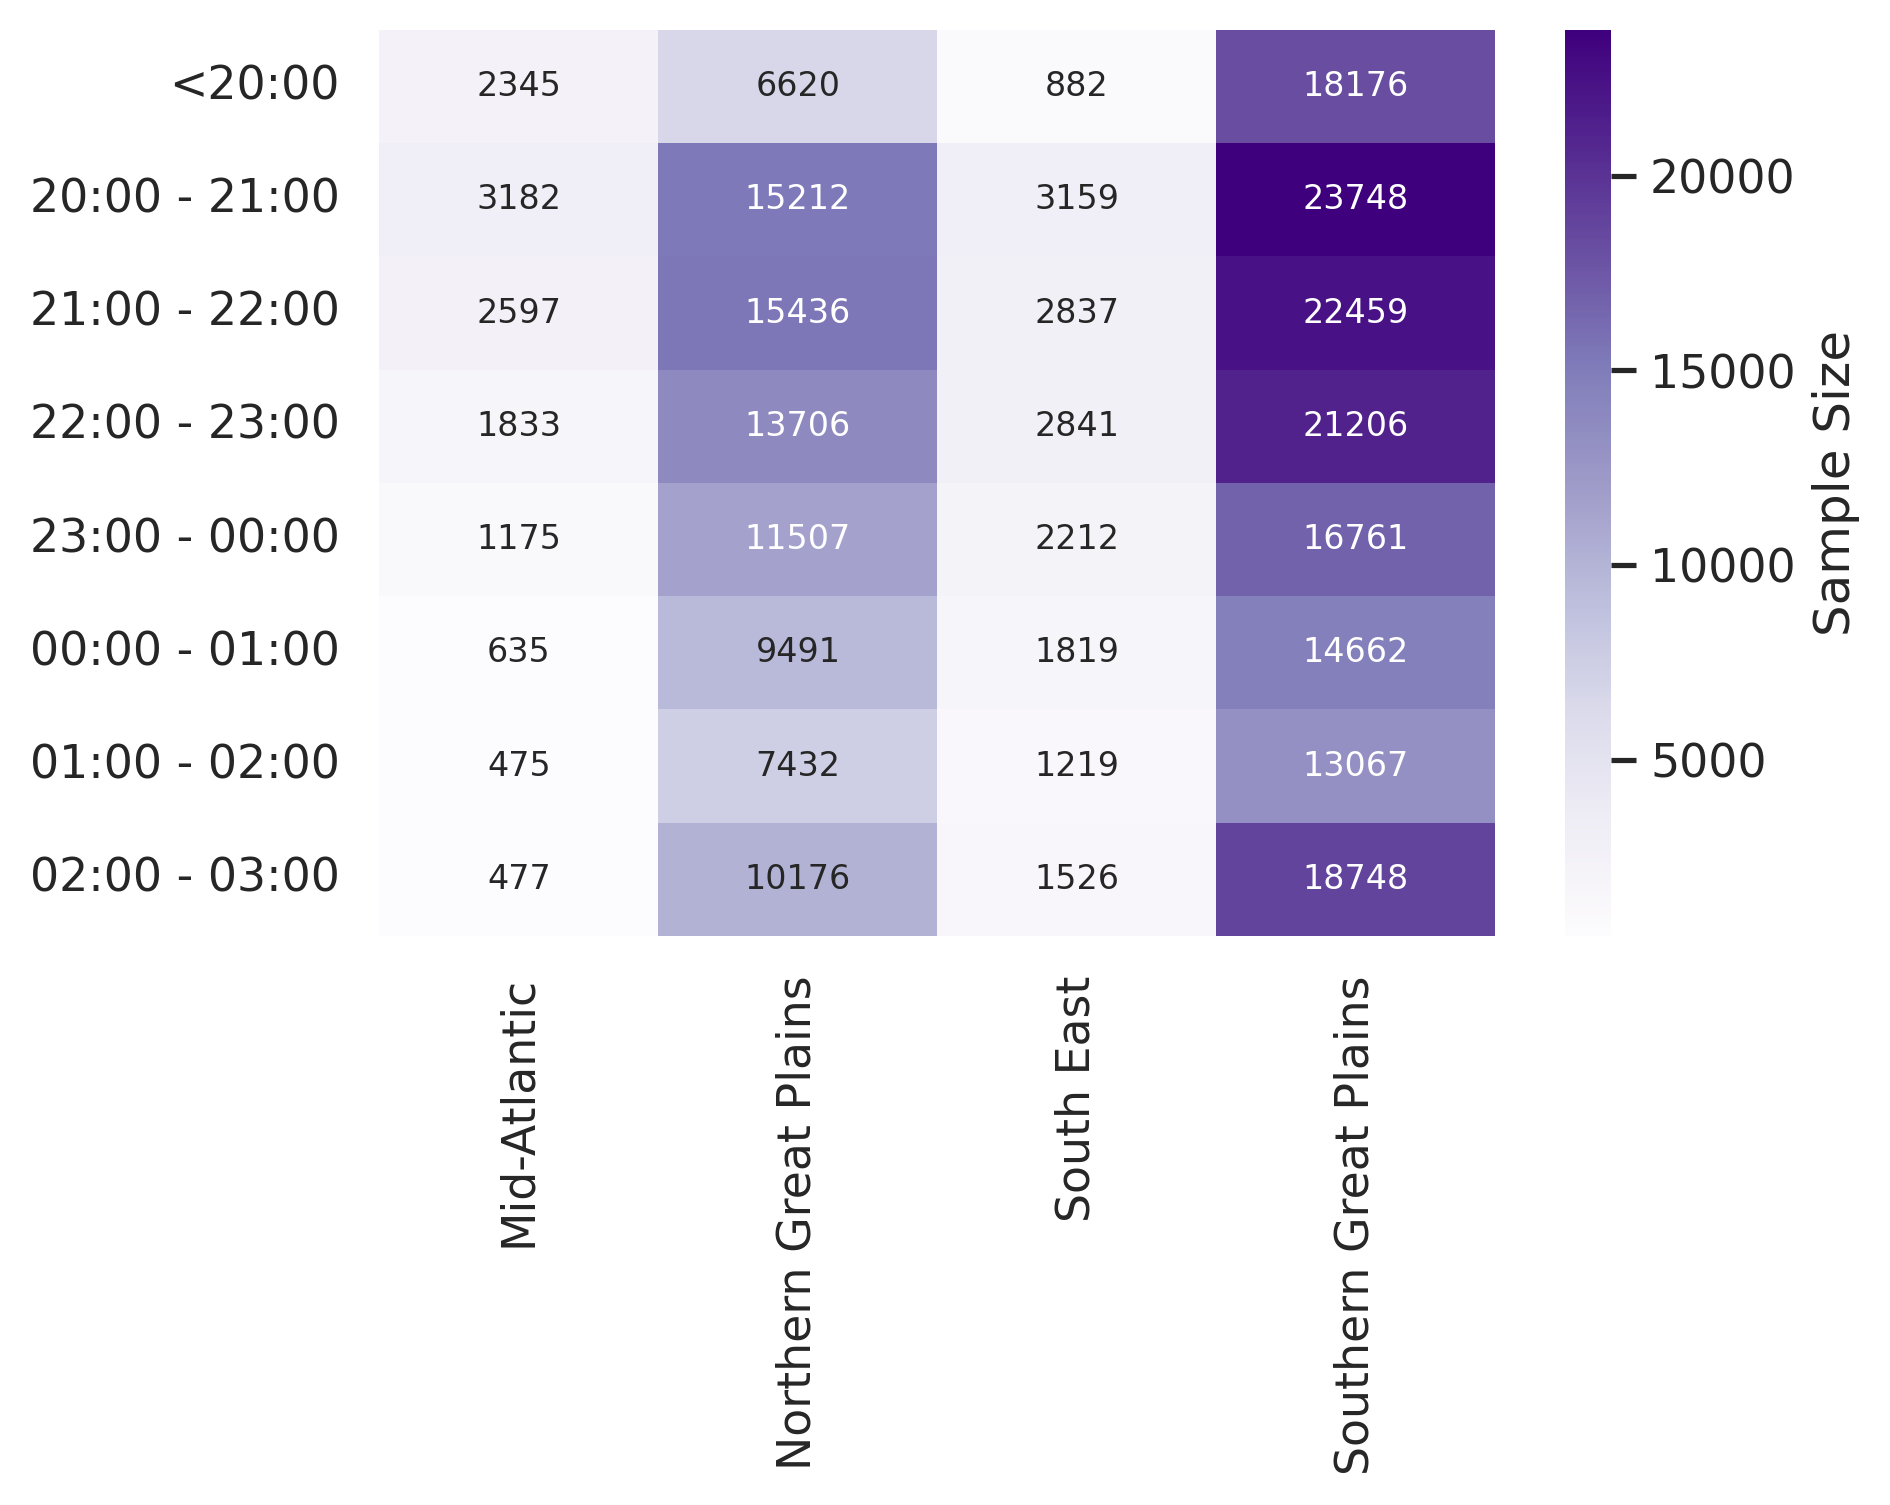

In [5]:
f, ax = plt.subplots(dpi=300)
Z, xedges, yedges = np.histogram2d(geography_int, 
                                   init_time_int, bins=[len(x_vals), len(y_vals)], 
                                   density=False)

sns.heatmap(Z.T.astype(int), ax=ax, annot=True, cbar_kws={'label': 'Sample Size'}, 
            cmap = 'Purples', annot_kws={'fontsize': 8}, fmt='')

ax.set_xticks([0.5+i for i,_ in enumerate(x_vals)])
ax.set_xticklabels(x_vals)
ax.tick_params(axis='x', labelrotation = 90)

ax.set_yticks([i+0.5 for i,_ in enumerate(y_vals)])
ax.set_yticklabels(y_vals)
ax.tick_params(axis='y', labelrotation =360)

#f.colorbar(cont)

In [6]:
def binning_2d(x,y,y_true, bins):
    """
    Binning of a third variable by two other variables. 
    """
    _,_,_,indices = binned_statistic_2d(x, y, None, 'count', 
                                    bins=bins, expand_binnumbers=True)
    y_bin_indices = indices[1,:]
    x_bin_indices = indices[0,:]

    size_x = bins[0]
    size_y = bins[1]
    
    skew = np.zeros((size_x, size_y))

    for i,j in itertools.product(np.unique(x_bin_indices), np.unique(y_bin_indices)):
        where_is_item = np.where((x_bin_indices==i) & (y_bin_indices==j))[0]
        i-=1; j-=1
        skew[i,j] = np.mean(y_true[where_is_item]) if len(where_is_item) > 0 else 0.
        
    return skew 

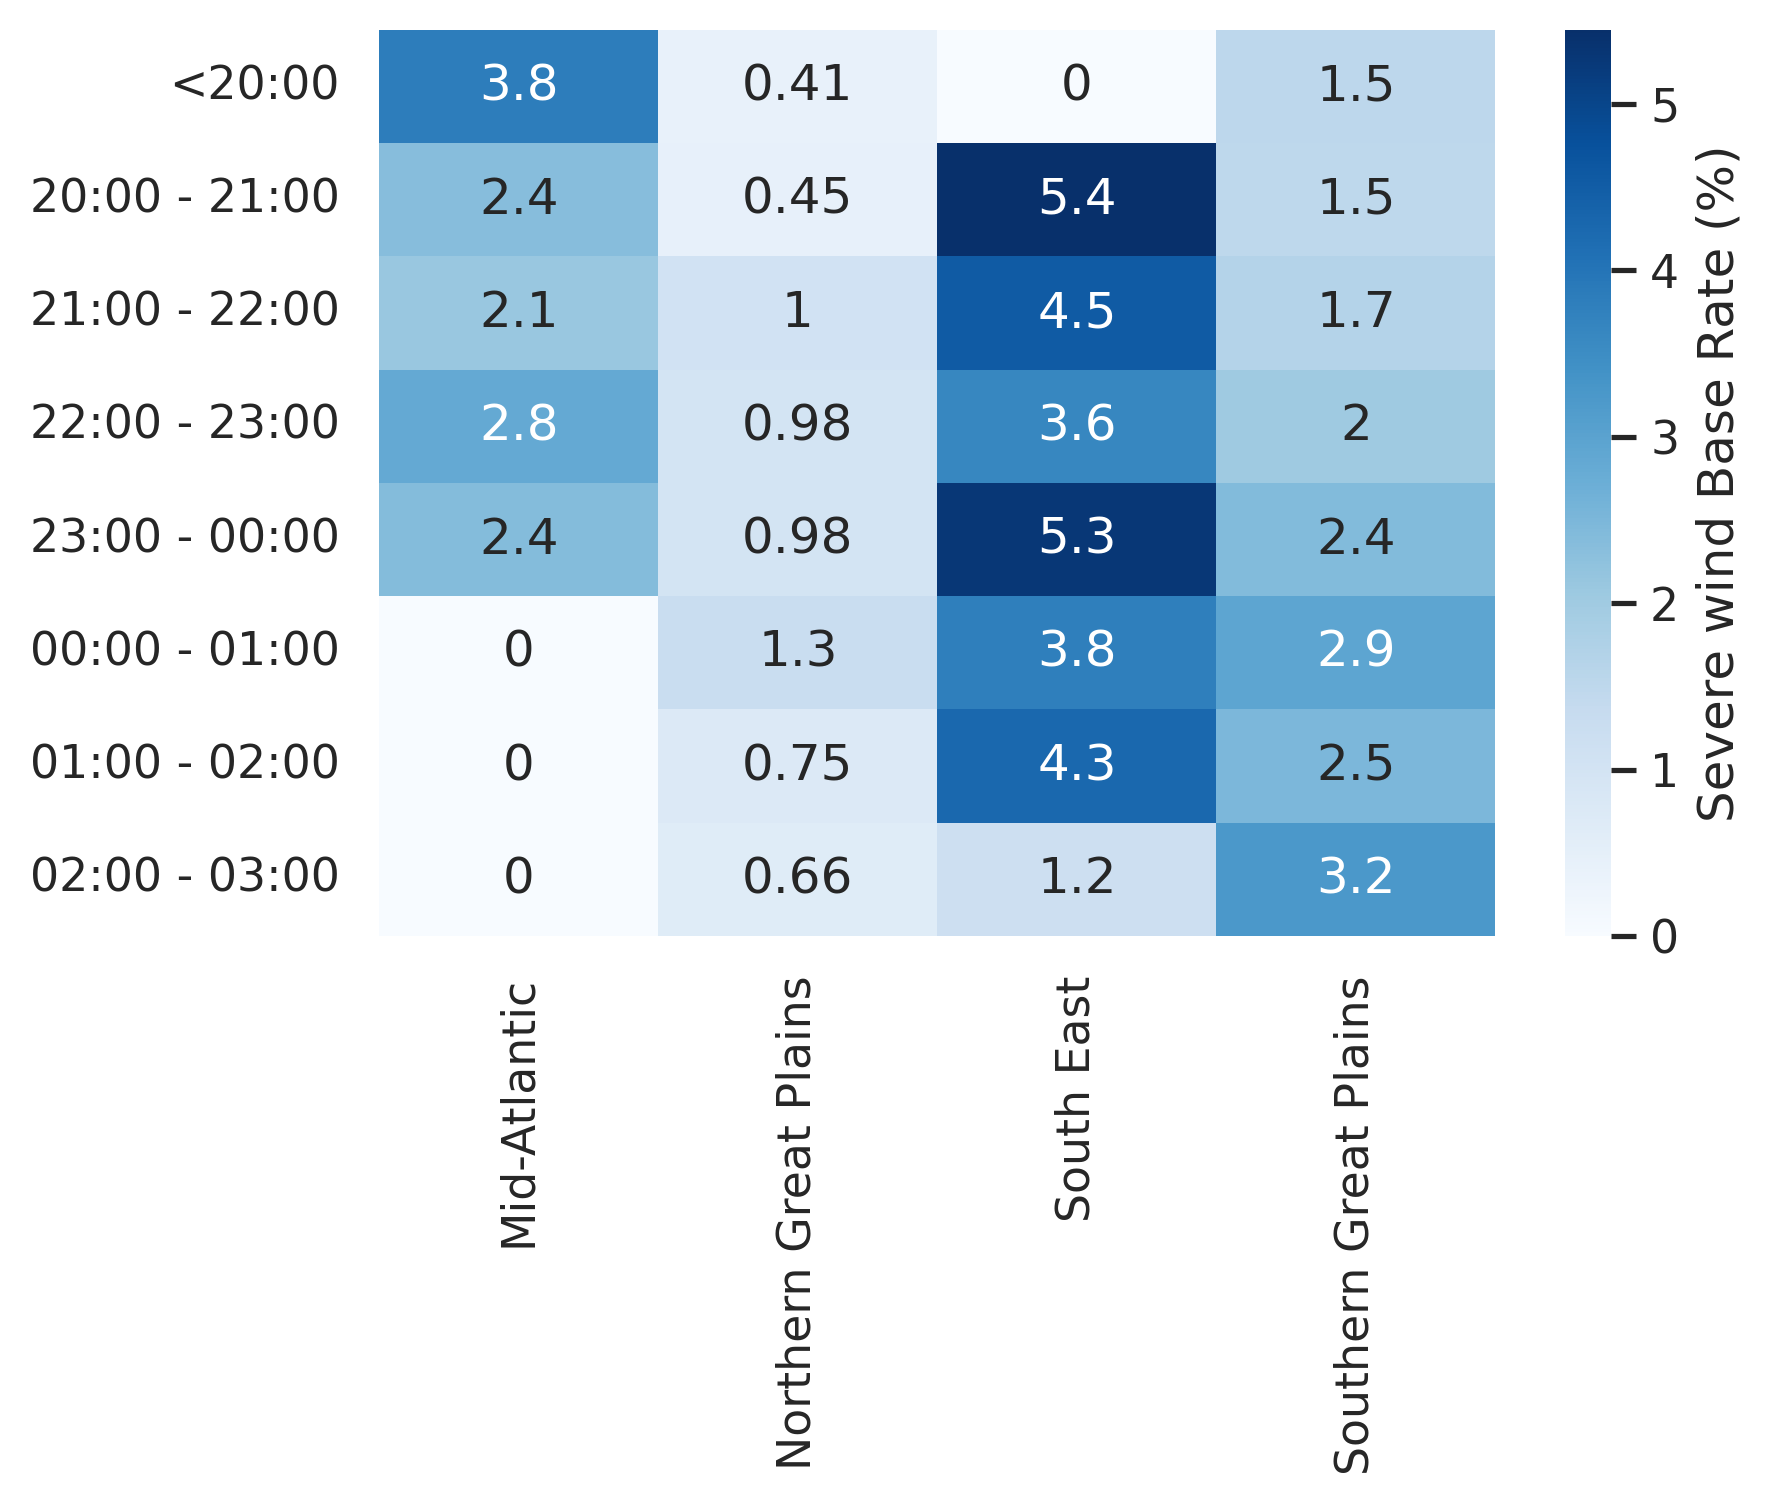

In [7]:
skew = binning_2d(geography_int, init_time_int, y, bins=[len(x_vals), len(y_vals)],)
f, ax = plt.subplots(dpi=300)

sns.heatmap(skew.T*100., 
            ax=ax, annot=True, cbar_kws={'label': f"{target.replace('_', ' ').capitalize()} Base Rate (%)"}, 
            cmap=cmap[target])

ax.set_xticks([0.5+i for i,_ in enumerate(x_vals)])
ax.set_xticklabels(x_vals)
ax.tick_params(axis='x', labelrotation = 90)

ax.set_yticks([i+0.5 for i,_ in enumerate(y_vals)])
ax.set_yticklabels(y_vals)
ax.tick_params(axis='y', labelrotation =360)

In [8]:
data = {'Geography' : geography, 'Initialization Time' : init_time_rng}
df = pd.DataFrame(data)

In [9]:
grouped_df = df.groupby('Initialization Time').value_counts().unstack('Geography')

<AxesSubplot:xlabel='Initialization Time'>

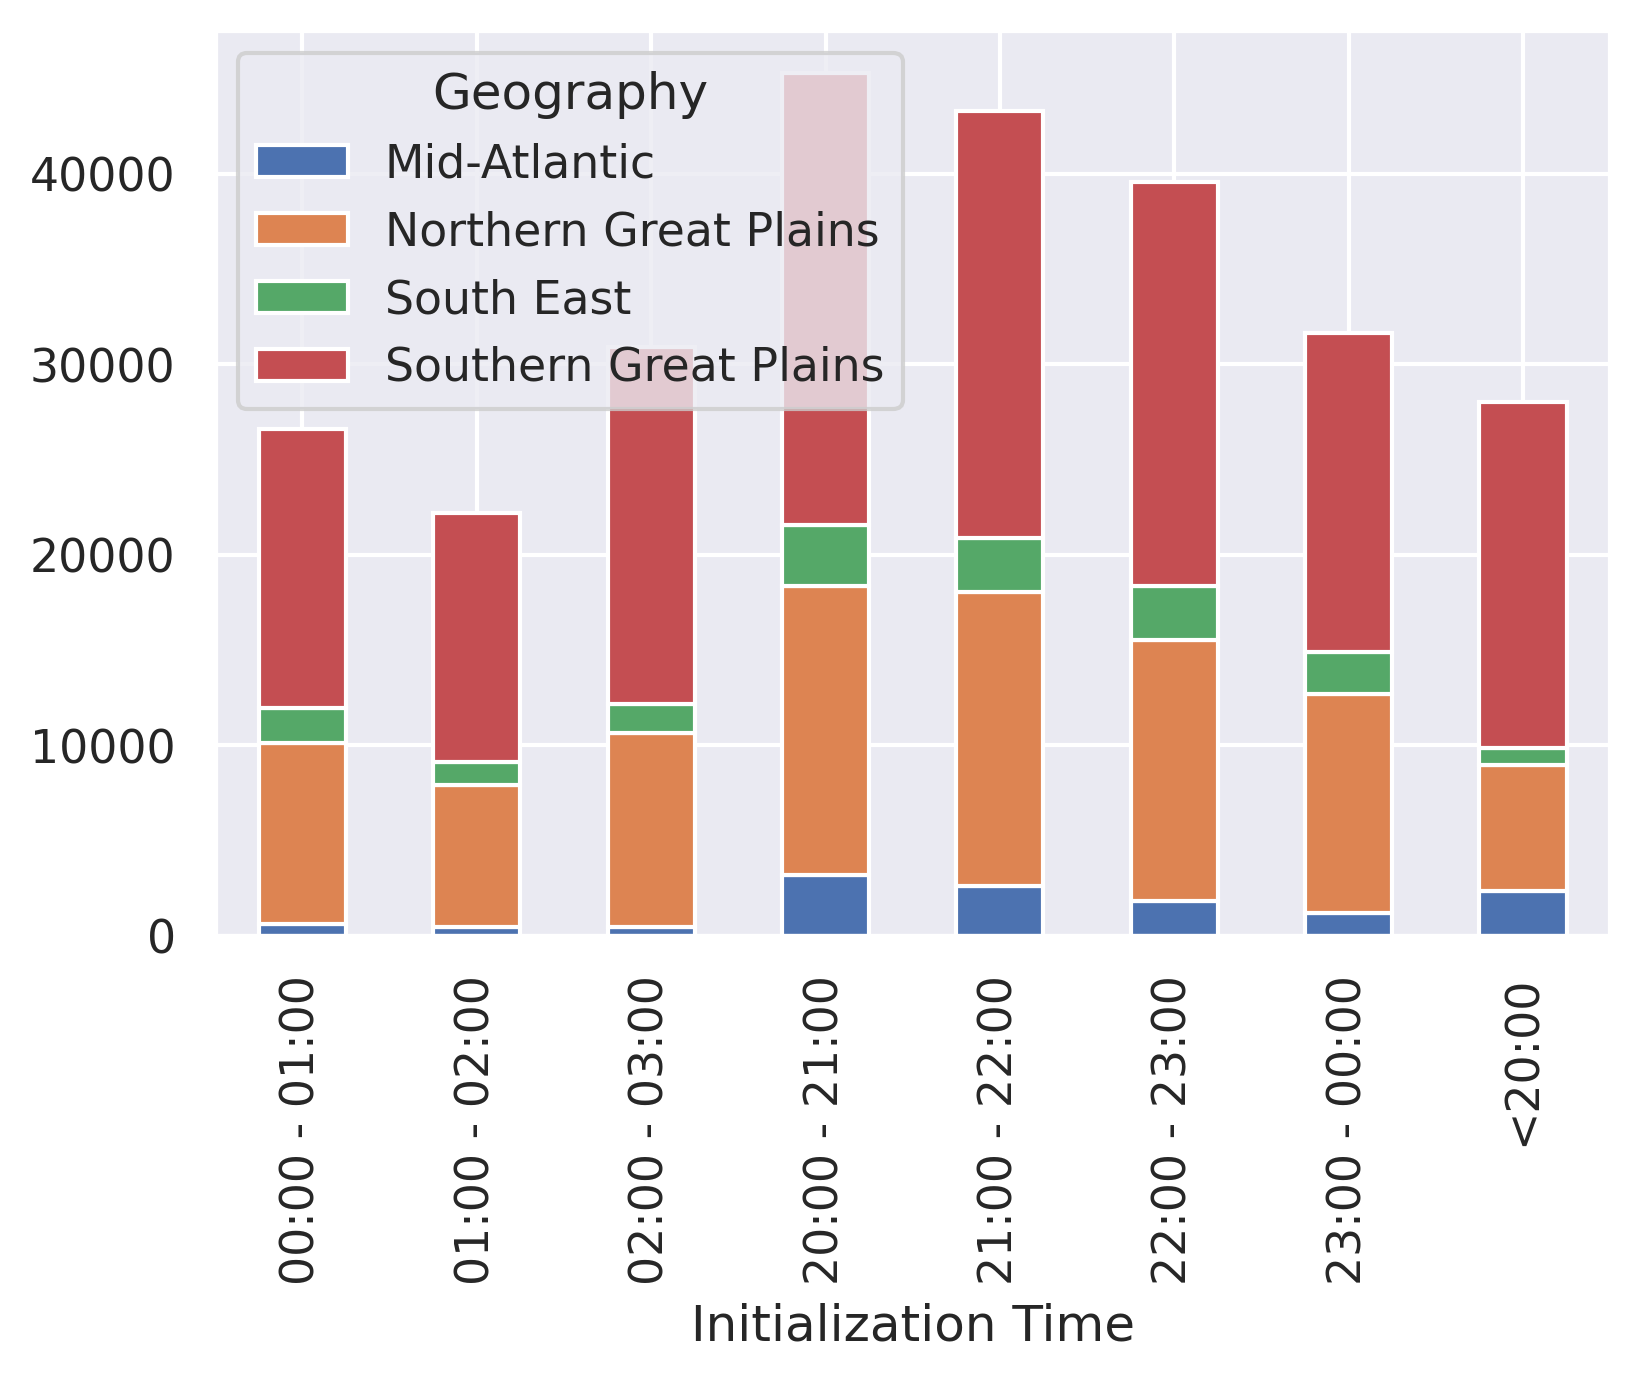

In [10]:
f, ax = plt.subplots(dpi=300)
grouped_df.plot(kind='bar', stacked=True, ax=ax)